### Laptsuev Rodion task_3 Wunderfund.

In [228]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import ml_metrics as metrics
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline
import random

In [373]:
data=open("prices_hist.txt").read().split('\n')
del data[-1]
data=map(float,data)
df = pd.DataFrame(data)
df.index = pd.to_datetime(df.index, unit='h')

In [6]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)


### Сначала посмотрим как все выглядит из графика ниже очевидно что ряд нестационарный.

In [7]:
plotly_df(df, title = "prices")

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

### Тест так же подтвердил гипотезу о нестационарности и показал, что сущесвует некоторая автокорреляция

Критерий Дики-Фуллера: p=0.383657


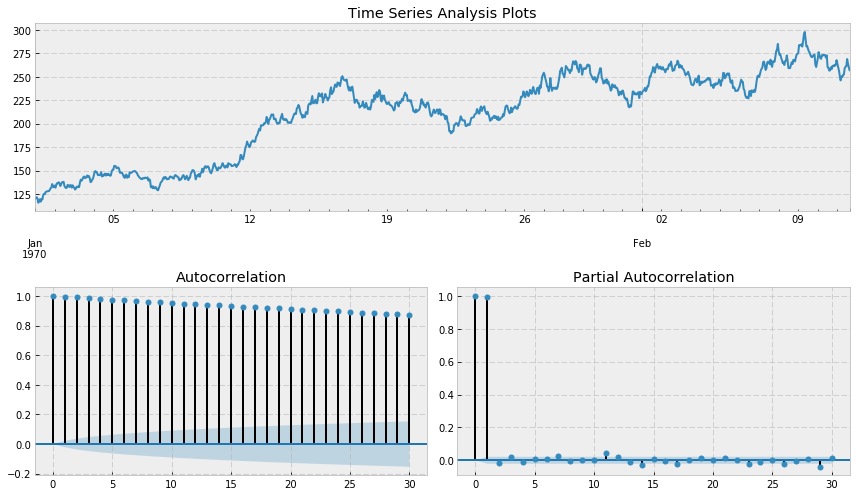

In [11]:
tsplot(df[0], lags=30)

###  Построим ряд первых разностей и посмотрим на его стационарность. 

In [12]:
diff = df.diff(periods=1).dropna()

In [13]:
plotly_df(diff, title = "prices")

Критерий Дики-Фуллера: p=0.000000


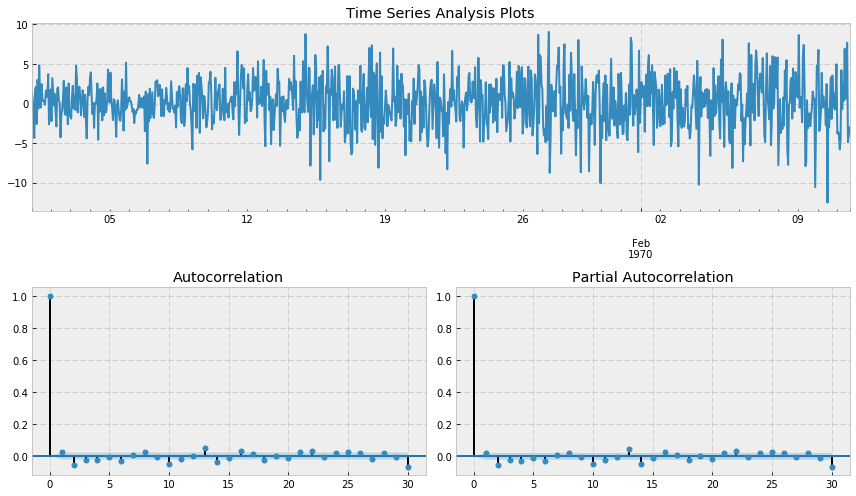

In [14]:
tsplot(diff[0], lags=30)

### Отлично получили стационарный ряд с ним можно работать. Так же не видно сильной автокорреляции в этом ряде и значит мы можем построить модель Arima и, используя ее, предсказать 1400 значение ряда.

In [421]:
ps = range(0, 5)
d=1
qs = range(0, 5)
parameters = product(ps, qs)
parameters_list = list(parameters)

### Попробуем подобрать параметры методом перебора для данной модели (параметры целые значения). Нашли что минимальный AIC&BIC будут с параметрами (0,0) 

In [429]:
min_bic=float("inf")
par_bic={}
for i in parameters_list:
    try:
        model = sm.tsa.ARIMA(df[0], order=(i[0], d, i[1])).fit(disp=0)
        par_bic[i]=model.bic
        if min_bic>model.bic:
            min_bic=model.bic
            optimal_par=[i[0],i[1]]
    except:
        print('bad par'+' '+str(i[0])+" "+str(i[1]))
optimal_par

bad par 1 1
bad par 1 2
bad par 1 3
bad par 1 4
bad par 2 3
bad par 2 4
bad par 3 3
bad par 3 4


[0, 0]

In [430]:
min_aic=float("inf")
par_aic={}
for i in parameters_list:
    try:
        model = sm.tsa.ARIMA(df[0], order=(i[0], d, i[1])).fit(disp=0)
        par_aic[i]=model.aic
        if min_bic>model.aic:
            min_bic=model.aic
            optimal_par=[i[0],i[1]]
    except:
        print('bad par'+' '+str(i[0])+" "+str(i[1]))
optimal_par

bad par 1 1
bad par 1 2
bad par 1 3
bad par 1 4
bad par 2 3
bad par 2 4
bad par 3 3
bad par 3 4


[0, 0]

In [433]:
from operator import itemgetter
sorted(par_bic.items(), key=itemgetter(1))

[((0, 0), 5122.1061767595756),
 ((0, 1), 5128.4395812107014),
 ((1, 0), 5128.5037571112725),
 ((0, 2), 5132.1041142295117),
 ((2, 0), 5132.1840492345482),
 ((2, 1), 5137.5184279161513),
 ((0, 3), 5138.4586093804091),
 ((3, 0), 5138.6709406521331),
 ((2, 2), 5143.3716209485092),
 ((3, 1), 5144.1679680946336),
 ((0, 4), 5144.5399544689399),
 ((4, 0), 5144.7586513768356),
 ((3, 2), 5146.882669877953),
 ((4, 1), 5151.0275854350666),
 ((4, 2), 5153.7053258337746),
 ((4, 3), 5158.2132708432937),
 ((4, 4), 5167.7263161409601)]

In [434]:
from operator import itemgetter
sorted(par_aic.items(), key=itemgetter(1))

[((0, 0), 5112.2926672022786),
 ((0, 2), 5112.477095114918),
 ((3, 2), 5112.535386427413),
 ((2, 0), 5112.557030119954),
 ((2, 1), 5112.984654022908),
 ((0, 1), 5113.719316874755),
 ((1, 0), 5113.7834927753265),
 ((0, 3), 5113.924835487166),
 ((2, 2), 5113.931092276618),
 ((4, 3), 5114.052477835457),
 ((3, 0), 5114.13716675889),
 ((4, 2), 5114.4512876045865),
 ((3, 1), 5114.7274394227425),
 ((0, 4), 5115.099425797049),
 ((4, 0), 5115.3181227049445),
 ((4, 1), 5116.6803019845265),
 ((4, 4), 5118.658768354475)]

### Получили что не зависит от предидущих значений так-как оба коэффициента равны 0. И пробуя различные модели кросс валидации она оказывается лучшей то есть значения ряда первых разностей не автокоррелированы и модель здесь не то что бы была нужна, но уже есть, будет пользоваться с параметрами 0,0.

In [452]:
model = sm.tsa.ARIMA(df[0][0:400], order=(0, d, 0)).fit(disp=0)
pred = model.predict(400,549,typ='levels')
sd1=metrics.mae(df[0][400:550],pred)
sd1

23.680641614035437

(array([ 14.,  22.,  11.,  11.,  10.,  16.,  12.,  27.,  20.,   7.]),
 array([-56.71747895, -49.90993719, -43.10239544, -36.29485368,
        -29.48731193, -22.67977018, -15.87222842,  -9.06468667,
         -2.25714491,   4.55039684,  11.3579386 ]),
 <a list of 10 Patch objects>)

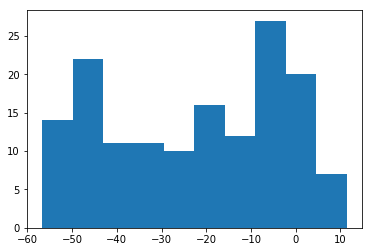

In [453]:
plt.hist(df[0][400:550]-pred)

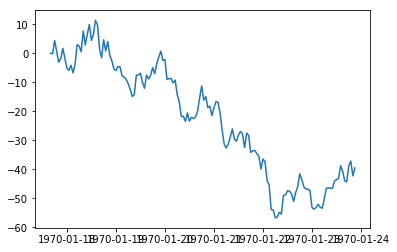

In [455]:
plt.plot(df[0][400:550]-pred)

In [456]:
model = sm.tsa.ARIMA(df[0][0:550], order=(0, d, 0)).fit(disp=0)
pred = model.predict(550,749,typ='levels')
sd2=metrics.mae(df[0][550:750],pred)
sd2

12.752421844262237

(array([  5.,   9.,  29.,  28.,  19.,  30.,  30.,  12.,  26.,  12.]),
 array([-30.92784098, -24.79692525, -18.66600951, -12.53509377,
         -6.40417803,  -0.2732623 ,   5.85765344,  11.98856918,
         18.11948492,  24.25040066,  30.38131639]),
 <a list of 10 Patch objects>)

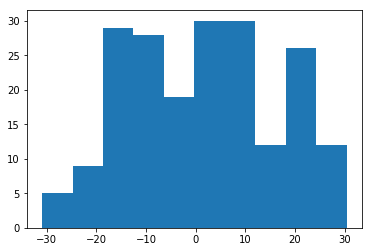

In [457]:
plt.hist(df[0][550:750]-pred)

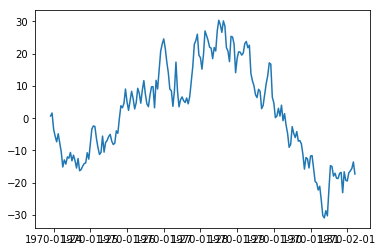

In [458]:
plt.plot(df[0][550:750]-pred)

In [459]:
model = sm.tsa.ARIMA(df[0][0:750], order=(0, d, 0)).fit(disp=0)
pred = model.predict(750,999,typ='levels')
sd3=metrics.mae(df[0][750:1000],pred)
sd3

11.07822111348456

(array([ 11.,  16.,  19.,  36.,  44.,  47.,  22.,  29.,  24.,   2.]),
 array([-26.90448318, -20.87796226, -14.85144134,  -8.82492041,
         -2.79839949,   3.22812143,   9.25464235,  15.28116327,
         21.30768419,  27.33420511,  33.36072603]),
 <a list of 10 Patch objects>)

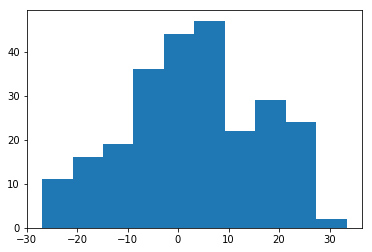

In [460]:
plt.hist(df[0][750:1000]-pred)

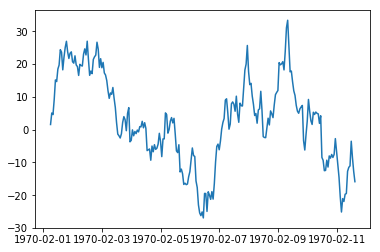

In [461]:
plt.plot(df[0][750:1000]-pred)

In [462]:
sd=(float(150)/600)*sd1+(float(200)/600)*sd2+(float(250)/600)*sd3
sd

14.786893148881504

### Средняя ошибка предсказания на тестовой выборке оказалась равной sd. Взвешивания были сделанны по размерам тестовых выборок. Теперь предскажем 1400 значение воспользовавшись нашей моделью.

In [467]:
model = sm.tsa.ARIMA(df[0], order=(0, d, 0)).fit(disp=0)

In [468]:
pred = model.predict(1,1400,typ='levels')

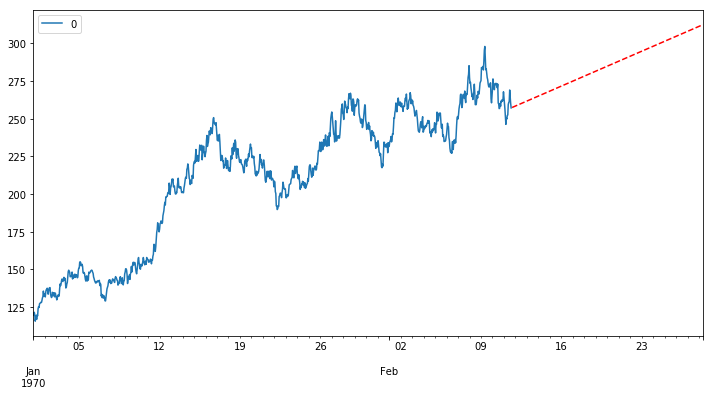

In [469]:
df.plot(figsize=(12,6))
pred[1000:].plot(style='r--')

In [470]:
pred[1399]

312.37005125124392

### Сгенерируем случайную величину со средним как у нашего предсказания и отклонением полученным с помощью кросс валидации.

In [475]:
nrm=list()
for i in range(10000000):
    nrm.append(random.gauss(pred[1399],sd))

### Применим к значениям полученной выборки функцию выигрыша, после чего посчитаем среднее (мат ожидание выигрыша) и отклонение, что и будет погрешностью нашей оценки. 

In [476]:
win=list()
for i in nrm:
    if i>300:
        win.append((300-i)**2)
    else:
        win.append(0)

In [477]:
np.mean(win)

348.17052531239091

In [478]:
np.std(win)

486.04432328919268